In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [115]:
import numpy as np
import pandas as pd
import datetime as dt
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# View Columns in first row of measurement
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1204ecb70>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [31]:
# Get all measurement data
m_df = pd.read_sql(session.query(measurement).statement, engine)
m_df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [40]:
# Get most recent measurement
most_recent = max(m_df["date"])
most_recent = dt.datetime.strptime(most_recent, '%Y-%m-%d')

2017-08-23 00:00:00


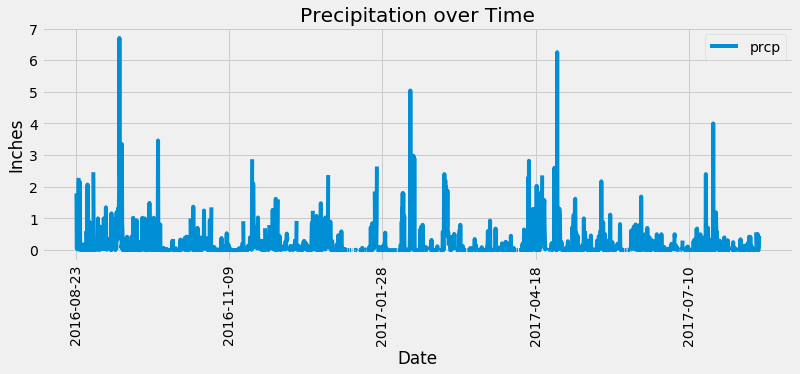

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
start_date = dt.date(most_recent.year - 1, most_recent.month, most_recent.day)
start_date
# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement).filter(measurement.date>=start_date)
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year = pd.read_sql(result.statement, engine)
# Sort the dataframe by date
last_year.sort_values(by="date", inplace = True)
last_year
# Use Pandas Plotting with Matplotlib to plot the data
last_year.plot(x="date", y="prcp", title="Precipitation over Time", rot=90, figsize=(12,4))
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

In [68]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year.describe()

,id,prcp,tobs
count,2230.000000,2021.000000,2230.000000
mean,10158.570404,0.177279,74.590583
std,5603.500203,0.461190,4.611667
min,2364.000000,0.000000,58.000000
25%,5287.250000,0.000000,72.000000
50%,8930.500000,0.020000,75.000000
75%,14750.750000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


# Exploratory Station Analysis

In [69]:
#lets just look at all stations
station_df = pd.read_sql(session.query(station).statement, engine)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [72]:
# Design a query to calculate the total number stations in the dataset
num_station = session.query(station).count()
print(f"There are {num_station} stations")

There are 9 stations


In [87]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# EDIT: I really could have done this in pandas and it would have been a lot easier... 
# but I guess this would be useful against a larger dataset

most_active_stations = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [102]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active_stations[0][0]
station_name = station_df.set_index("station").loc[most_active_id, "name"]
recordings = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station==most_active_id).all()
recordings

[(54.0, 85.0, 71.66378066378067)]

In [104]:
print(f"The most active station is {most_active_id} at {station_name}")
print(f"The minimum recorded temp there was {recordings[0][0]} degrees")
print(f"The maximum recorded was {recordings[0][1]} degrees")
print(f"and the average temperature was {recordings[0][2]:.1f} degrees")

The most active station is USC00519281 at WAIHEE 837.5, HI US
The minimum recorded temp there was 54.0 degrees
The maximum recorded was 85.0 degrees
and the average temperature was 71.7 degrees


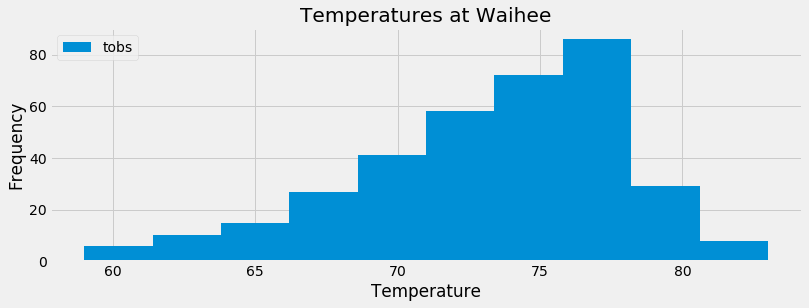

In [111]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# EDIT. I'm not going to do that. I already queried the data. I get we are practicing queries, but in a real work
# setting I wouldn't duplicate the call to the DB
waihee_df = last_year[last_year["station"]==most_active_id]
waihee_df.plot(y="tobs", kind="hist", title="Temperatures at Waihee", figsize=(12,4))
plt.legend(loc="upper left")
plt.xlabel("Temperature")
plt.show()

# Close session

In [112]:
# Close Session
session.close()

# Test API functions

In [121]:
# Create our session (link) from Python to the DB
session = Session(engine)

"""Return a list of all precipitation data"""
# Query all precipitation data
results = dict(session.query(measurement.date, measurement.prcp).all())

session.close()

#jsonify results
jsonify(results)

RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in some way. To solve
this, set up an application context with app.app_context().  See the
documentation for more information.

In [120]:
dict(results)

{'2010-01-01': 0.14,
 '2010-01-02': 0.0,
 '2010-01-03': 0.0,
 '2010-01-04': 0.0,
 '2010-01-06': 0.36,
 '2010-01-07': 0.3,
 '2010-01-08': 0.0,
 '2010-01-09': 0.0,
 '2010-01-10': 0.01,
 '2010-01-11': 0.14,
 '2010-01-12': 0.0,
 '2010-01-14': 0.0,
 '2010-01-15': 0.0,
 '2010-01-16': 0.0,
 '2010-01-17': 0.0,
 '2010-01-18': 0.0,
 '2010-01-19': 0.0,
 '2010-01-20': 0.0,
 '2010-01-21': 0.32,
 '2010-01-22': 0.0,
 '2010-01-23': 0.0,
 '2010-01-24': 0.01,
 '2010-01-25': 0.0,
 '2010-01-26': 0.03,
 '2010-01-27': 0.31,
 '2010-01-28': 0.07,
 '2010-01-30': 0.33,
 '2010-01-31': 1.1,
 '2010-02-01': 0.01,
 '2010-02-03': 0.67,
 '2010-02-04': 0.0,
 '2010-02-05': 0.09,
 '2010-02-06': 0.04,
 '2010-02-07': 0.0,
 '2010-02-08': 0.0,
 '2010-02-09': 0.0,
 '2010-02-11': 0.0,
 '2010-02-12': 0.65,
 '2010-02-13': 0.62,
 '2010-02-14': 0.02,
 '2010-02-15': 0.0,
 '2010-02-16': 0.0,
 '2010-02-17': 0.02,
 '2010-02-19': 0.42,
 '2010-02-20': 0.55,
 '2010-02-21': 0.0,
 '2010-02-22': None,
 '2010-02-23': 0.0,
 '2010-02-24': 0.0,